# Clustering

Clustering is one of the types of unsupervised learning. It is similar to classification: the aim is to give a label to each data point. However, unlike in classification, we not given any examples of data points and their labels. We must infer from the data, which data points belong to the same cluster. This can be achieved using the notion of distance between the data points. Data points in the same cluster are somehow close to each other.

One of the simplest clustering methods is k-means clustering. It aims at producing a clustering that is optimal in the following sense:
* the centre of each cluster is the average of all points in the cluster
* any point in a cluster is closer to its centre than to a centre of any other cluster

The k-means clustering is first given the wanted number of clusters as hyperparameter, say k. Then, to start the algorithm, k points from the data set are chosen randomly as cluster centres. Then the following phases are repeated iteratively:
* any data point is set to belong to a cluster, whose centre is closest to it
* then for each cluster a new centre is chosen as the average of the data points in the cluster

This procedure is repeated until the clusters no longer change. This kind of algorithm is called an Expectation-Maximization (EM) algorithm, which is known to converge.

## Simple example

The scikit-learn library has an implementation of the k-means algorithm. Let's apply it to a set of randomly generated blobs, whose labels we throw away.

In [181]:
import numpy as np
%matplotlib inline

In [179]:
from sklearn.datasets import make_blobs
X,y = make_blobs(centers=4, n_samples=200, random_state=0, cluster_std=1.2)
print(X[:10],y[:10])

[[ 2.41315333  2.48932674]
 [-0.58331046  2.35817935]
 [ 1.18918145  3.8216502 ]
 [-3.95493285  6.6084518 ]
 [ 1.16156173 -0.09406259]
 [ 0.9888701   6.44683192]
 [-1.89996742  3.03476246]
 [-0.08907282  1.92683157]
 [ 2.4526189   5.74664315]
 [ 1.85117875  4.45856682]] [1 2 0 3 1 0 2 0 0 0]


Now we plot these points, but without coloring the points using the labels:

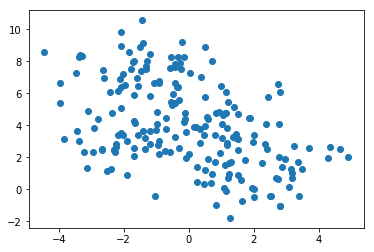

In [182]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1]);

We can still discern four clusters in the data set. Let's see if the k-means algorithm can recover these clusters. First we create the instance of the k-means model by given it the number of clusters 4 as a hyperparameter.

In [183]:
from sklearn.cluster import KMeans
model = KMeans(4)
model.fit(X)
print(model.cluster_centers_)

[[-1.42178189  7.56931534]
 [ 0.92503649  4.39562613]
 [-1.89774928  3.02042556]
 [ 2.08734049  0.95221181]]


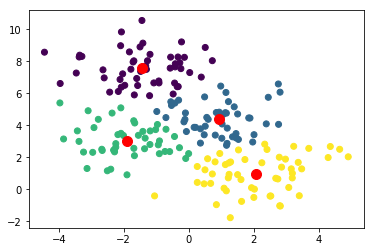

In [184]:
plt.scatter(X[:,0],X[:,1], c=model.labels_);
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=100, color="red")

The clustering looks more or less correct. To get a more quantitative measure of success we can get the accuracy score.

In [185]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(y, model.labels_)
print("Accuracy score is", acc)

Accuracy score is 0.25


Oops! Even though the clusters could match almost perfectly to the original, their labels might be permuted. Let's select randomly one point from each cluster and check their labels from the original data labels. Then we use this label for the whole cluster. In essence, we are renaming the clusters, not re-clustering the data.

In [187]:
import scipy
def find_permutation(n_clusters, real_labels, labels):
    permutation=[]
    for i in range(n_clusters):
        idx = labels == i
        new_label=scipy.stats.mode(real_labels[idx])[0][0]  # Choose the most common label among data points in the cluster
        permutation.append(new_label)
    return permutation

In [188]:
permutation = find_permutation(4, y, model.labels_)
print(permutation)

[3, 0, 2, 1]


In [124]:
new_labels = [ permutation[label] for label in model.labels_]   # permute the labels
print("Accuracy score is", accuracy_score(y, new_labels))

Accuracy score is 0.885


So, the k-means algorithm seems to work well in this case, but the can be several problems. Firstly, even though an EM algorithm always converges, it might converge to a local maximum. To avoid this, EM type algorithms are usually run several times, each time starting from different random initial values. For instance, in the scikit-learn implementation, the algorithms is restarted by default 10 times. Let's see what happens, if we set it to run only once.

Accuracy score is 0.89


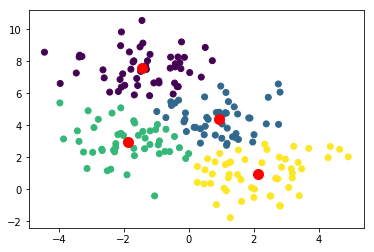

In [190]:
model = KMeans(4, n_init=1, random_state=13, init="random")
model.fit(X)
permutation2 = find_permutation(4, y, model.labels_)
#print(model.cluster_centers_)
plt.scatter(X[:,0],X[:,1], c=model.labels_);
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=100, color="red");
print("Accuracy score is", accuracy_score(y, [ permutation2[label] for label in model.labels_]))

## More complicated example

The k-means algorithm can have difficulties when the clusters are not convex shapes:

In [142]:
from sklearn.datasets import make_moons
X,y = make_moons(200, noise=0.05, random_state=0)

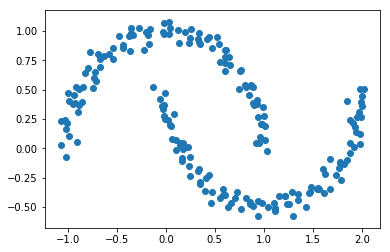

In [143]:
plt.scatter(X[:,0], X[:,1]);

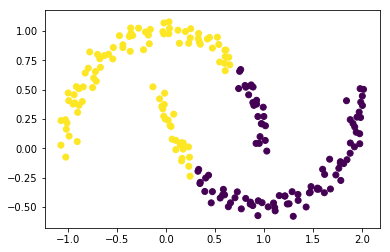

In [145]:
model=KMeans(2)
model.fit(X)
plt.scatter(X[:,0], X[:,1], c=model.labels_);

The clustering does not work well now, since it is not possible to separate the two clusters with a line. We could embed this data set into a higher dimensional space, where the separation is possible. And then apply the k-means clustering.

Alternatively, we can use a different type of clustering algorithm for this case. The DBSCAN algorithm is based on densities and works well on data whose density in the clusters is uniform.

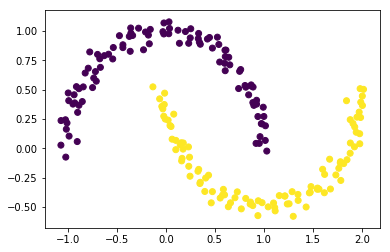

In [151]:
from sklearn.cluster import DBSCAN
model = DBSCAN(0.3)
model.fit(X)
plt.scatter(X[:,0], X[:,1], c=model.labels_);

The good news is that DBSCAN does not require the user to specify the number of clusters. But now the algorithm depends on another hyperparameter: a threshold for distance (here 0.3).

## Clustering digits

In [152]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

To get an idea how these data points look like, we plot first ten of these.

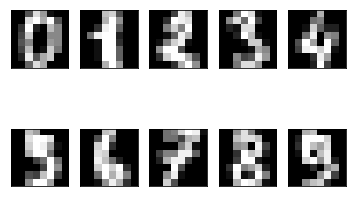

In [160]:
fig, axes = plt.subplots(2,5, subplot_kw=dict(xticks=[], yticks=[]))
for ax, digit in zip(axes.flat, digits.data[:10]):
    ax.imshow(digit.reshape(8,8), cmap="gray")

Let's cluster these data points.

In [176]:
model=KMeans(n_clusters = 10, random_state=0)
model.fit(digits.data)
model.cluster_centers_.shape

(10, 64)

So, we have ten cluster centres, which are images with 8x8=64 pixels in them. We can have a look at their appearence:

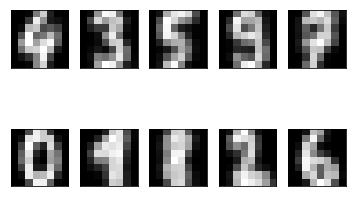

In [162]:
fig, axes = plt.subplots(2,5, subplot_kw=dict(xticks=[], yticks=[]))
for ax, digit in zip(axes.flat, model.cluster_centers_):
    ax.imshow(digit.reshape(8,8), cmap="gray")

One can recognize these numbers with the exception of maybe number eight. What is the accuracy score of this clustering?

In [178]:
permutation3 = find_permutation(10, digits.target, model.labels_)
print(permutation3)
acc = accuracy_score(digits.target, [ permutation3[label] for label in model.labels_])
print("Accuracy score is", acc)

[4, 3, 5, 9, 7, 0, 1, 8, 2, 6]
Accuracy score is 0.7935447968836951


#### <div class="alert alert-info">Exercise 9 (plant clustering)</div>

Using the same iris data set that you saw earlier in the classification, apply k-means clustering with 3 clusters.
Create a function plant_clustering that loads the iris data set, clusters the data and return the accuracy_score.

#### <div class="alert alert-info">Exercise 10 (nonconvex clusters)</div>

Read the tab separated file data.tsv from the src folder into a dataframe. The dataset has two features X1 and X2, and the label y. Cluster the feature matrix using DBSCAN using different values for the eps parameter. Use values in np.arange(0.05, 0.2, 0.05) for clustering. For each clustering, collect the accuracy score, the number of clusters, and the number of outliers. Return these values in a dataframe, where eps is the index and the columns are names as in the below example.

Note that DBSCAN uses label -1 to denote outliers , that is, those data points that didn't fit well in any cluster. You have to modify the find_permutation function to handle this: ignore the outlier data points from the accuracy score computation. In addition, if the number of clusters is not the same as the number of labels in the original data, set the accuracy score to NaN.

         eps   Score  Clusters  Outliers                             
    0    0.05      ?         ?         ?
    1    0.10      ?         ?         ?
    2    0.15      ?         ?         ?
    3    0.20      ?         ?         ?

Before submitting the solution, you can plot the data set (with clusters colored) to see what kind of data we are dealing with.

Points are given for each correct column in the result dataframe.

#### <div class="alert alert-info">Exercise 11 ()</div>